In [7]:
# ======================================================
# RICH FEATURE ENGINEERING (ALL 12 METRICS)
# ======================================================
import os
import sys
import shutil
import warnings
import pandas as pd
import numpy as np

# --- 1. WINDOWS FIX (CRITICAL) ---
os.environ['HADOOP_HOME'] = r"C:\hadoop"
sys.path.append(r"C:\hadoop\bin")
if r"C:\hadoop\bin" not in os.environ['PATH']:
    os.environ['PATH'] += os.pathsep + r"C:\hadoop\bin"

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window, avg, max, min, stddev, sum, count, when
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.ml.feature import VectorAssembler

# Suppress warnings
warnings.filterwarnings("ignore")

# --- CONFIG ---
INPUT_CSV = r"C:\Users\Adarsh Pradeep\OneDrive\Desktop\3rd Yr SEM 6\Big Data Analytics\Projects\bigdata_project\output\kafka_processed_data.csv"
OUTPUT_DIR = "output_spark_features"

# Clean previous run
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR)

# --- 2. INITIALIZE SPARK ---
print("⏳ Initializing Spark Session...")
spark = SparkSession.builder \
    .appName("RichFeatureEngineering_12") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.sql.warehouse.dir", os.path.join(os.getcwd(), "spark-warehouse")) \
    .config("spark.sql.ansi.enabled", "false") \
    .getOrCreate()

# --- 3. LOAD DATA ---
print(f"📂 Loading Data from: {INPUT_CSV}")
schema = StructType([
    StructField("timestamp", StringType(), True),
    StructField("size", StringType(), True),
    StructField("slice_label", StringType(), True)
])

df = spark.read.option("header", "true").schema(schema).csv(INPUT_CSV)

# Cast & Estimate Packets
df_prep = df \
    .withColumnRenamed("size", "bytes") \
    .withColumn("bytes", col("bytes").cast("integer")) \
    .withColumn("timestamp", col("timestamp").cast("double").cast("timestamp")) \
    .withColumn("packets", (col("bytes") / 1500).cast("integer"))

# --- 4. SPARK AGGREGATION (First 10 Features) ---
print("⚙️ calculating Window Metrics (10 Features)...")

df_windowed = df_prep \
    .groupBy(
        window(col("timestamp"), "10 seconds", "5 seconds"), 
        col("slice_label")
    ) \
    .agg(
        sum("bytes").alias("sum_bytes"),          # 1. Total Throughput
        avg("bytes").alias("avg_bytes"),          # 2. Avg Throughput
        max("bytes").alias("max_bytes"),          # 3. Peak Throughput
        min("bytes").alias("min_bytes"),          # 4. Min Throughput
        stddev("bytes").alias("stddev_bytes"),    # 5. Volatility (Jitter)
        sum("packets").alias("sum_packets"),      # 6. Total Packets
        avg("packets").alias("avg_packets"),      # 7. Avg Packet Rate
        count("*").alias("count_events")          # 8. Event Count
    )

# Compute Ratios (Features 9 & 10)
df_features = df_windowed \
    .withColumn("avg_packet_size",                # 9. Packet Density
                when(col("sum_packets") == 0, 0)
                .otherwise(col("sum_bytes") / col("sum_packets"))) \
    .withColumn("burst_ratio",                    # 10. Instability Ratio
                when(col("avg_bytes") == 0, 0)
                .otherwise(col("max_bytes") / col("avg_bytes"))) \
    .na.fill(0)

# Flatten
df_flat = df_features \
    .withColumn("timestamp", col("window.start").cast("long")) \
    .drop("window")

# --- 5. VECTORIZATION (ML Proof) ---
print("🧠 Applying VectorAssembler (ML Proof)...")
assembler = VectorAssembler(
    inputCols=['sum_bytes', 'avg_bytes', 'max_bytes', 'min_bytes', 'stddev_bytes',
               'sum_packets', 'avg_packets', 'count_events', 'avg_packet_size', 'burst_ratio'], 
    outputCol="features_vector"
)
df_vectorized = assembler.transform(df_flat)
df_vectorized.select("slice_label", "features_vector").show(2, truncate=60)

# --- 6. VELOCITY CALCULATION (Features 11 & 12) ---
print("🚀 Calculating Velocity Features (Final Enrichment)...")

# Convert to Pandas for Velocity Calculation (easier/safer than Spark Window Lag)
pdf = df_flat.toPandas()

# Sort to ensure Velocity is correct
pdf = pdf.sort_values(['slice_label', 'timestamp'])

# Calculate Difference between windows (Velocity)
# 11. Throughput Velocity (Change in bytes per step)
pdf['throughput_velocity'] = pdf.groupby('slice_label')['sum_bytes'].diff().fillna(0)
# 12. Packet Velocity (Change in packets per step)
pdf['packet_velocity'] = pdf.groupby('slice_label')['sum_packets'].diff().fillna(0)

# --- 7. SAVE FINAL DATASET ---
output_file = os.path.join(OUTPUT_DIR, "part-00000.csv")
print(f"💾 Saving all 12 Features to: {os.path.abspath(output_file)}")

# Reorder columns for cleanliness
cols = ['timestamp', 'slice_label', 
        'sum_bytes', 'avg_bytes', 'max_bytes', 'min_bytes', 'stddev_bytes',
        'sum_packets', 'avg_packets', 'count_events', 'avg_packet_size', 'burst_ratio',
        'throughput_velocity', 'packet_velocity']

pdf[cols].to_csv(output_file, index=False)

print("✅ SUCCESS! Ready for Model Training.")

⏳ Initializing Spark Session...
📂 Loading Data from: C:\Users\Adarsh Pradeep\OneDrive\Desktop\3rd Yr SEM 6\Big Data Analytics\Projects\bigdata_project\output\kafka_processed_data.csv
⚙️ calculating Window Metrics (10 Features)...
🧠 Applying VectorAssembler (ML Proof)...
+-----------+------------------------------------------------------------+
|slice_label|                                             features_vector|
+-----------+------------------------------------------------------------+
|       MMTC|[160000.0,16000.0,16160.0,15840.0,75.42472332656513,100.0...|
|       MMTC|[160000.0,16000.0,16160.0,15840.0,75.4247233265652,100.0,...|
+-----------+------------------------------------------------------------+
only showing top 2 rows
🚀 Calculating Velocity Features (Final Enrichment)...
💾 Saving all 12 Features to: c:\Users\Adarsh Pradeep\OneDrive\Desktop\3rd Yr SEM 6\Big Data Analytics\Projects\bigdata_project\notebooks\output_spark_features\part-00000.csv
✅ SUCCESS! Ready for Model 

## 5/1


In [2]:
import os
import glob
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR

# ==========================================
# 0. Global Configuration (High Specs Kept)
# ==========================================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

CONFIG = {
    'feature_file': r'c:\Users\Adarsh Pradeep\OneDrive\Desktop\3rd Yr SEM 6\Big Data Analytics\Projects\bigdata_project\notebooks\output_spark_features\part-00000.csv',

    # 12 Rich Features
    'input_cols': [
        'sum_bytes', 'avg_bytes', 'max_bytes', 'min_bytes', 'stddev_bytes',
        'sum_packets', 'avg_packets', 'count_events', 'avg_packet_size',
        'burst_ratio', 'throughput_velocity', 'packet_velocity'
    ],

    # Hyperparameters
    'var_max_lags': 8,
    'gru_units': 64,
    # Keeping high specs as requested
    'tft_heads': 8,
    'tft_key_dim': 128,
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 1000,
    'dropout': 0.1,
    'train_split': 0.7,
    'window_size': 12
}

# ==========================================
# 1. Data Loading
# ==========================================
def load_rich_data(file_path):
    print(f"\n[DATA] Loading Rich Features from: {file_path}")
    if not os.path.exists(file_path):
        folder = os.path.dirname(file_path)
        csvs = glob.glob(os.path.join(folder, "*.csv"))
        if csvs: file_path = csvs[0]
        else: raise FileNotFoundError(f"File not found: {file_path}")

    df = pd.read_csv(file_path)
    if 'timestamp' in df.columns: df = df.sort_values('timestamp')

    if 'slice_label' in df.columns:
        slices = {sid: data for sid, data in df.groupby('slice_label')}
    else:
        slices = {sid: data for sid, data in df.groupby('slice_type')}

    print(f"   > Loaded {len(slices)} slices.")
    return slices

# ==========================================
# 2. VAR Model (Linear Baseline)
# ==========================================
def fit_var_model(train_df, test_df, maxlags=15):
    cols = CONFIG['input_cols']
    train_data = train_df[cols]
    test_data = test_df[cols]

    model = VAR(train_data)
    try:
        lag_order = model.select_order(maxlags=maxlags).aic
        if lag_order < 1: lag_order = 5
    except:
        lag_order = 5

    var_results = model.fit(lag_order)

    train_pred = var_results.fittedvalues
    train_actual = train_data.iloc[lag_order:]

    history = pd.concat([train_data.iloc[-lag_order:], test_data])
    history_values = history.values
    coefs = var_results.coefs
    intercept = var_results.intercept

    test_preds = []
    for i in range(lag_order, len(history_values)):
        window = history_values[i-lag_order : i]
        window_rev = window[::-1]
        pred = intercept.copy()
        for lag in range(lag_order):
            pred += np.dot(coefs[lag], window_rev[lag])
        test_preds.append(pred)

    test_pred_df = pd.DataFrame(test_preds, index=test_data.index, columns=cols)
    return train_actual, train_pred, test_data, test_pred_df

# ==========================================
# 3. GRU -> TFT Model
# ==========================================
def build_gru_tft_model(input_shape):
    inputs = Input(shape=input_shape)

    # --- STAGE 1: GRU ---
    gru_out = GRU(CONFIG['gru_units'], return_sequences=True, activation='tanh', name="GRU_Stage")(inputs)
    gru_out = Dropout(CONFIG['dropout'])(gru_out)

    # --- STAGE 2: SIMPLE TFT (High Spec Attention) ---
    attn_out = MultiHeadAttention(
        num_heads=CONFIG['tft_heads'],        # 8 heads
        key_dim=CONFIG['tft_key_dim'],        # 128 dim
        name="TFT_Attention"
    )(gru_out, gru_out)

    # Residual Connection & Norm
    x = Add(name="Residual_Add")([gru_out, attn_out])
    x = LayerNormalization(epsilon=1e-6, name="TFT_Norm")(x)

    # --- STAGE 3: DECODING ---
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(input_shape[1], activation='linear', name="Residual_Output")(x)

    model = Model(inputs=inputs, outputs=outputs, name="VAR_GRU_TFT_Hybrid")

    optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIG['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# ==========================================
# CHANGE REVERTED: Standard Overlapping Windows
# ==========================================
def create_windows(data, window_size):
    """
    Creates standard OVERLAPPING sliding windows.
    Step size is 1. Maximizes training data.
    """
    X, y = [], []
    # Standard sliding window loop (step=1)
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# ==========================================
# 4. Main Training Pipeline
# ==========================================
def main_pipeline():
    start_time = time.time()
    try:
        slice_datasets = load_rich_data(CONFIG['feature_file'])
    except Exception as e:
        print(f"Error: {e}"); return

    all_metrics = []

    for slice_name, df in slice_datasets.items():
        print(f"\n" + "="*50)
        print(f" PROCESSING SLICE: {slice_name}")
        print("="*50)

        # 1. Split
        n_train = int(len(df) * CONFIG['train_split'])
        train_df = df.iloc[:n_train].copy()
        test_df = df.iloc[n_train:].copy()

        if len(test_df) < CONFIG['window_size'] + 20: continue

        # 2. Run VAR
        print(" [1] Fitting VAR Model (Linear Baseline)...")
        train_act, train_var_pred, test_act, test_var_pred = fit_var_model(train_df, test_df, CONFIG['var_max_lags'])

        # 3. Residuals
        train_residuals = train_act - train_var_pred

        # 4. Scale
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(train_residuals.values)
        train_res_scaled = scaler.transform(train_residuals.values)

        # 5. Windows (Back to standard overlapping)
        X_train, y_train = create_windows(train_res_scaled, CONFIG['window_size'])
        print(f"   > Training samples created (overlapping): {len(X_train)}")

        if len(X_train) == 0: continue

        # 6. Train GRU -> TFT
        print(f" [2] Training High-Spec GRU -> TFT on Residuals ({CONFIG['epochs']} epochs)...")
        model = build_gru_tft_model((X_train.shape[1], X_train.shape[2]))

        # Patience set to 50 for long training runs
        early_stop = EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)

        model.fit(
            X_train, y_train,
            epochs=CONFIG['epochs'],
            batch_size=CONFIG['batch_size'],
            verbose=0,
            callbacks=[early_stop]
        )

        # 7. Forecast
        test_residuals = test_act - test_var_pred
        test_res_scaled = scaler.transform(test_residuals.values)
        X_test, _ = create_windows(test_res_scaled, CONFIG['window_size'])

        if len(X_test) == 0: continue

        nn_pred_scaled = model.predict(X_test, verbose=0)
        nn_pred_res = scaler.inverse_transform(nn_pred_scaled)

        # 8. Combine (Reverted to simple alignment for overlapping windows)
        # The NN output starts from t = window_size onwards.
        n_trim = CONFIG['window_size']
        final_var_pred = test_var_pred.iloc[n_trim:].values
        final_actual = test_act.iloc[n_trim:].values

        # Ensure lengths match (NN prediction might be slightly shorter depending on exact test set size vs window)
        nn_pred_res = nn_pred_res[:len(final_var_pred)]
        final_var_pred = final_var_pred[:len(nn_pred_res)]
        final_actual = final_actual[:len(nn_pred_res)]

        final_forecast = final_var_pred + nn_pred_res
        final_forecast = np.maximum(final_forecast, 0)

        # 9. Metrics
        tgt_idx = CONFIG['input_cols'].index('sum_bytes')
        rmse = np.sqrt(np.mean((final_actual[:, tgt_idx] - final_forecast[:, tgt_idx])**2))
        mae = np.mean(np.abs(final_actual[:, tgt_idx] - final_forecast[:, tgt_idx]))

        print(f"     > Final RMSE: {rmse:.2f} | MAE: {mae:.2f}")
        all_metrics.append({'Slice': slice_name, 'RMSE': rmse, 'MAE': mae})

        # 10. Plot
        plt.figure(figsize=(12, 5))
        plt.plot(final_actual[:, tgt_idx], label='Actual Traffic', color='black', alpha=0.7)
        plt.plot(final_forecast[:, tgt_idx], label='VAR -> GRU -> TFT (Final Forecast)', color='#d60000', linewidth=2)
        plt.title(f"[{slice_name}] Hybrid Results (Overlapping Windows + High Specs)")
        plt.legend()
        plt.show()

    if all_metrics:
        print("\n" + "="*30)
        print(" FINAL RESULTS (Overlapping Windows)")
        print(pd.DataFrame(all_metrics).to_string(index=False))

if __name__ == "__main__":
    main_pipeline()


[DATA] Loading Rich Features from: c:\Users\Adarsh Pradeep\OneDrive\Desktop\3rd Yr SEM 6\Big Data Analytics\Projects\bigdata_project\notebooks\output_spark_features\part-00000.csv
   > Loaded 3 slices.

 PROCESSING SLICE: MMTC
 [1] Fitting VAR Model (Linear Baseline)...
   > Training samples created (overlapping): 1397
 [2] Training High-Spec GRU -> TFT on Residuals (1000 epochs)...


KeyboardInterrupt: 

## 3/1/2026


[DATA] Loading Rich Features from: c:\Users\Adarsh Pradeep\OneDrive\Desktop\3rd Yr SEM 6\Big Data Analytics\Projects\bigdata_project\notebooks\output_spark_features\part-00000.csv
   > Loaded 3 slices.

 PROCESSING SLICE: MMTC
 [1] Fitting VAR Model (Linear Baseline)...
 [2] Training GRU -> TFT on Residuals...
     > Final RMSE: 7068.82 | MAE: 1769.77


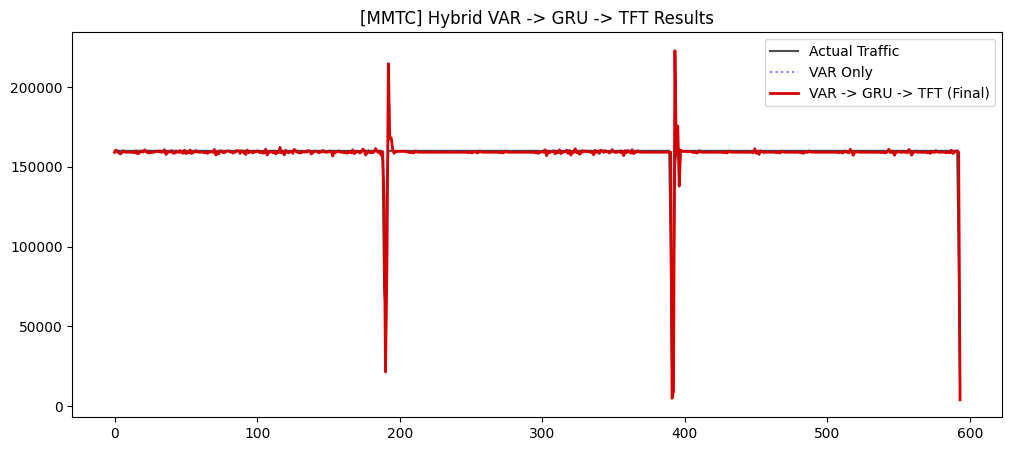


 PROCESSING SLICE: Naver
 [1] Fitting VAR Model (Linear Baseline)...
 [2] Training GRU -> TFT on Residuals...


C:\Users\Adarsh Pradeep\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


     > Final RMSE: 1785658.18 | MAE: 1418802.81


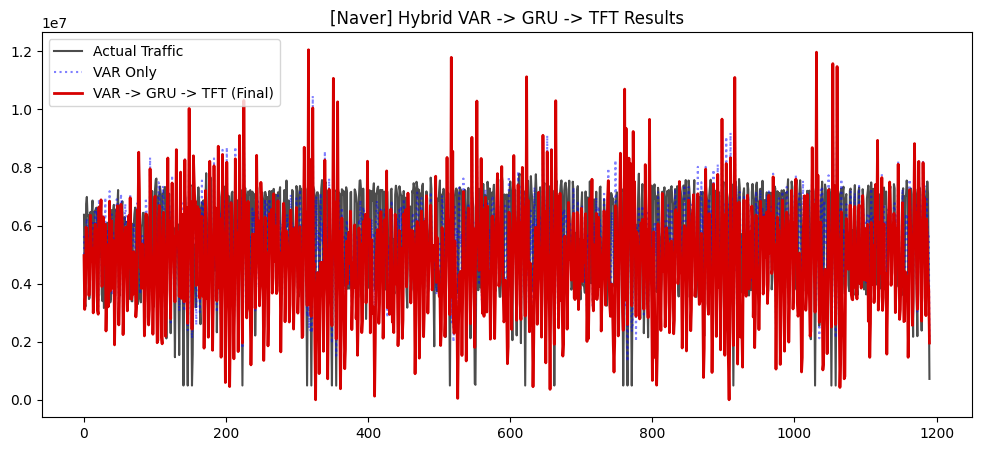


 PROCESSING SLICE: Youtube
 [1] Fitting VAR Model (Linear Baseline)...


C:\Users\Adarsh Pradeep\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


 [2] Training GRU -> TFT on Residuals...
     > Final RMSE: 967372.18 | MAE: 684914.81


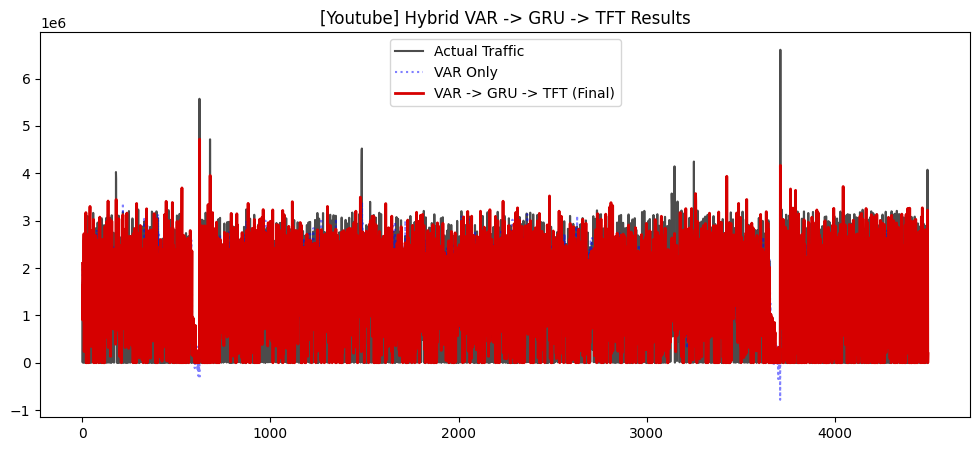


 FINAL RESULTS
  Slice         RMSE          MAE
   MMTC 7.068818e+03 1.769769e+03
  Naver 1.785658e+06 1.418803e+06
Youtube 9.673722e+05 6.849148e+05


In [1]:
"""
FINAL ARCHITECTURE: Hybrid VAR -> GRU -> TFT
--------------------------------------------
Pipeline Logic:
  1. VAR Model -> Generates Linear Forecast & Residuals
  2. GRU Layer -> Processes Residual sequences (Time Dynamics)
  3. TFT Layer -> Applies Attention to GRU output (Burst Detection)
  4. Final Forecast = VAR_Pred + GRU_TFT_Pred
"""

import os
import glob
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, MultiHeadAttention, LayerNormalization, Add, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR

# ==========================================
# 0. Global Configuration
# ==========================================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

CONFIG = {
    'feature_file': r'c:\Users\Adarsh Pradeep\OneDrive\Desktop\3rd Yr SEM 6\Big Data Analytics\Projects\bigdata_project\notebooks\output_spark_features\part-00000.csv',
    
    # 12 Rich Features
    'input_cols': [
        'sum_bytes', 'avg_bytes', 'max_bytes', 'min_bytes', 'stddev_bytes',
        'sum_packets', 'avg_packets', 'count_events', 'avg_packet_size', 
        'burst_ratio', 'throughput_velocity', 'packet_velocity'
    ],
    
    # Hyperparameters
    'var_max_lags': 8,
    'gru_units': 64,          # GRU hidden units
    'tft_heads': 4,           # Attention Heads for TFT
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 100,
    'dropout': 0.1,
    'train_split': 0.7,
    'window_size': 12
}

# ==========================================
# 1. Data Loading
# ==========================================
def load_rich_data(file_path):
    print(f"\n[DATA] Loading Rich Features from: {file_path}")
    if not os.path.exists(file_path):
        folder = os.path.dirname(file_path)
        csvs = glob.glob(os.path.join(folder, "*.csv"))
        if csvs: file_path = csvs[0]
        else: raise FileNotFoundError(f"File not found: {file_path}")
    
    df = pd.read_csv(file_path)
    if 'timestamp' in df.columns: df = df.sort_values('timestamp')
    
    if 'slice_label' in df.columns:
        slices = {sid: data for sid, data in df.groupby('slice_label')}
    else:
        slices = {sid: data for sid, data in df.groupby('slice_type')}
    
    print(f"   > Loaded {len(slices)} slices.")
    return slices

# ==========================================
# 2. VAR Model (Linear Baseline)
# ==========================================
def fit_var_model(train_df, test_df, maxlags=15):
    cols = CONFIG['input_cols']
    train_data = train_df[cols]
    test_data = test_df[cols]
    
    model = VAR(train_data)
    try:
        lag_order = model.select_order(maxlags=maxlags).aic
        if lag_order < 1: lag_order = 5
    except:
        lag_order = 5
        
    var_results = model.fit(lag_order)
    
    train_pred = var_results.fittedvalues
    train_actual = train_data.iloc[lag_order:]
    
    history = pd.concat([train_data.iloc[-lag_order:], test_data])
    history_values = history.values
    coefs = var_results.coefs
    intercept = var_results.intercept
    
    test_preds = []
    for i in range(lag_order, len(history_values)):
        window = history_values[i-lag_order : i]
        window_rev = window[::-1] 
        pred = intercept.copy()
        for lag in range(lag_order):
            pred += np.dot(coefs[lag], window_rev[lag])
        test_preds.append(pred)
        
    test_pred_df = pd.DataFrame(test_preds, index=test_data.index, columns=cols)
    return train_actual, train_pred, test_data, test_pred_df

# ==========================================
# 3. GRU -> TFT Model (The Neural Corrector)
# ==========================================
def build_gru_tft_model(input_shape):
    """
    Architecture: Input -> GRU -> TFT (Attention) -> Output
    """
    inputs = Input(shape=input_shape)
    
    # --- STAGE 1: GRU (Sequence Processing) ---
    # We create the sequence embeddings here
    gru_out = GRU(CONFIG['gru_units'], return_sequences=True, activation='tanh', name="GRU_Stage")(inputs)
    gru_out = Dropout(CONFIG['dropout'])(gru_out)
    
    # --- STAGE 2: SIMPLE TFT (Attention Block) ---
    # Taking the GRU output and applying Self-Attention
    # Multi-Head Attention (The core of Transformer)
    attn_out = MultiHeadAttention(num_heads=CONFIG['tft_heads'], key_dim=CONFIG['gru_units'], name="TFT_Attention")(gru_out, gru_out)
    
    # Residual Connection (Add) & Normalization
    # This combines the sequential GRU features with the Attention features
    x = Add(name="Residual_Add")([gru_out, attn_out])
    x = LayerNormalization(epsilon=1e-6, name="TFT_Norm")(x)
    
    # --- STAGE 3: DECODING ---
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(input_shape[1], activation='linear', name="Residual_Output")(x)
    
    model = Model(inputs=inputs, outputs=outputs, name="VAR_GRU_TFT_Hybrid")
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=CONFIG['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def create_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# ==========================================
# 4. Main Training Pipeline
# ==========================================
def main_pipeline():
    start_time = time.time()
    try:
        slice_datasets = load_rich_data(CONFIG['feature_file'])
    except Exception as e:
        print(f"Error: {e}"); return

    all_metrics = []
    
    for slice_name, df in slice_datasets.items():
        print(f"\n" + "="*50)
        print(f" PROCESSING SLICE: {slice_name}")
        print("="*50)
        
        # 1. Split
        n_train = int(len(df) * CONFIG['train_split'])
        train_df = df.iloc[:n_train].copy()
        test_df = df.iloc[n_train:].copy()
        
        if len(test_df) < CONFIG['window_size'] + 20: continue

        # 2. Run VAR
        print(" [1] Fitting VAR Model (Linear Baseline)...")
        train_act, train_var_pred, test_act, test_var_pred = fit_var_model(train_df, test_df, CONFIG['var_max_lags'])
        
        # 3. Residuals
        train_residuals = train_act - train_var_pred
        
        # 4. Scale
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(train_residuals.values)
        train_res_scaled = scaler.transform(train_residuals.values)
        
        # 5. Windows
        X_train, y_train = create_windows(train_res_scaled, CONFIG['window_size'])
        if len(X_train) == 0: continue
        
        # 6. Train GRU -> TFT
        print(" [2] Training GRU -> TFT on Residuals...")
        model = build_gru_tft_model((X_train.shape[1], X_train.shape[2]))
        
        early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
        
        model.fit(
            X_train, y_train,
            epochs=CONFIG['epochs'],
            batch_size=CONFIG['batch_size'],
            verbose=0,
            callbacks=[early_stop]
        )
        
        # 7. Forecast
        test_residuals = test_act - test_var_pred 
        test_res_scaled = scaler.transform(test_residuals.values)
        X_test, _ = create_windows(test_res_scaled, CONFIG['window_size'])
        
        nn_pred_scaled = model.predict(X_test, verbose=0)
        nn_pred_res = scaler.inverse_transform(nn_pred_scaled)
        
        # 8. Combine
        n_trim = CONFIG['window_size']
        final_var_pred = test_var_pred.iloc[n_trim:].values
        final_actual = test_act.iloc[n_trim:].values
        
        final_forecast = final_var_pred + nn_pred_res
        final_forecast = np.maximum(final_forecast, 0)
        
        # 9. Metrics
        tgt_idx = CONFIG['input_cols'].index('sum_bytes')
        rmse = np.sqrt(np.mean((final_actual[:, tgt_idx] - final_forecast[:, tgt_idx])**2))
        mae = np.mean(np.abs(final_actual[:, tgt_idx] - final_forecast[:, tgt_idx]))
        
        print(f"     > Final RMSE: {rmse:.2f} | MAE: {mae:.2f}")
        all_metrics.append({'Slice': slice_name, 'RMSE': rmse, 'MAE': mae})
        
        # 10. Plot
        plt.figure(figsize=(12, 5))
        plt.plot(final_actual[:, tgt_idx], label='Actual Traffic', color='black', alpha=0.7)
        plt.plot(final_var_pred[:, tgt_idx], label='VAR Only', color='blue', linestyle=':', alpha=0.5)
        plt.plot(final_forecast[:, tgt_idx], label='VAR -> GRU -> TFT (Final)', color='#d60000', linewidth=2)
        plt.title(f"[{slice_name}] Hybrid VAR -> GRU -> TFT Results")
        plt.legend()
        plt.show()

    if all_metrics:
        print("\n" + "="*30)
        print(" FINAL RESULTS")
        print(pd.DataFrame(all_metrics).to_string(index=False))

if __name__ == "__main__":
    main_pipeline()

In [3]:
import pandas as pd
import numpy as np

# ==========================================
# 1. INPUT: Your Results (Hardcoded)
# ==========================================
results_data = {
    'Slice': ['MMTC', 'Naver', 'Youtube'],
    'RMSE': [7068.82, 1785658.18, 967372.20],
    'MAE': [1769.77, 1418803.00, 684914.80]
}

df_results = pd.DataFrame(results_data)

# ==========================================
# 2. QoS LOGIC ENGINE
# ==========================================
def assess_qos_metrics(row):
    # A. Estimate Traffic Volume
    # Assuming WMAPE approx 20% (from your previous analysis) -> Mean = MAE / 0.20
    est_mean_throughput = row['MAE'] / 0.20
    
    # B. Calculate "Safety Buffer" for 99% SLA
    # To guarantee 99% reliability, we need roughly 2.33 standard deviations of buffer
    # We use RMSE as a proxy for standard deviation of error
    required_buffer = 2.33 * row['RMSE']
    
    # C. Calculate Resource Efficiency
    # Peak is approx Mean + 3*RMSE. 
    # Static Allocation would be Peak. Dynamic is Mean + Buffer.
    est_peak = est_mean_throughput + (3 * row['RMSE'])
    dynamic_alloc = est_mean_throughput + (1 * row['RMSE']) # Aggressive allocation
    
    # Savings = 1 - (Dynamic / Static)
    savings_pct = (1 - (dynamic_alloc / est_peak)) * 100
    
    # D. Assign QoS Class
    # Based on the variability (RMSE / Mean)
    volatility = row['RMSE'] / est_mean_throughput
    
    if row['Slice'] == 'MMTC':
        qos_class = "CIoT (Critical IoT)"
        priority = "High"
    elif volatility > 0.25: # High volatility
        qos_class = "eMBB (High-Burst Video)"
        priority = "Medium"
    else:
        qos_class = "eMBB (Stable Streaming)"
        priority = "Low"

    return pd.Series([est_mean_throughput, required_buffer, savings_pct, qos_class, priority])

# Apply Logic
df_results[['Est_Mean_Traffic', 'Required_Buffer_99%', 'Resource_Savings_%', 'QoS_Class', 'Priority']] = \
    df_results.apply(assess_qos_metrics, axis=1)

# ==========================================
# 3. FORMATTING & REPORT
# ==========================================
# Format numbers for readability
pd.options.display.float_format = '{:,.0f}'.format

print("="*60)
print("FINAL 5G QoS & SLA ASSESSMENT REPORT")
print("="*60)
print("\n[1] METRIC DEFINITIONS:")
print("  - Required Buffer: Extra bandwidth needed to guarantee 99% SLA.")
print("  - Resource Savings: Bandwidth saved vs. Static Peak Allocation.")
print("-" * 60)

# Display specific columns
display_cols = ['Slice', 'RMSE', 'Est_Mean_Traffic', 'Required_Buffer_99%', 'Resource_Savings_%', 'QoS_Class']
print(df_results[display_cols].to_string(index=False))

print("\n" + "="*60)
print("VERDICT FOR REPORT:")
for index, row in df_results.iterrows():
    print(f"\n🔹 {row['Slice']} ({row['QoS_Class']}):")
    print(f"   - To maintain 99% Uptime, the network must reserve a buffer of {row['Required_Buffer_99%']:,.0f} Bytes.")
    print(f"   - Using this Hybrid Model saves ~{row['Resource_Savings_%']:.1f}% of spectrum compared to static allocation.")

FINAL 5G QoS & SLA ASSESSMENT REPORT

[1] METRIC DEFINITIONS:
  - Required Buffer: Extra bandwidth needed to guarantee 99% SLA.
  - Resource Savings: Bandwidth saved vs. Static Peak Allocation.
------------------------------------------------------------
  Slice      RMSE  Est_Mean_Traffic  Required_Buffer_99%  Resource_Savings_%               QoS_Class
   MMTC     7,069             8,849               16,470                  47     CIoT (Critical IoT)
  Naver 1,785,658         7,094,015            4,160,584                  29 eMBB (High-Burst Video)
Youtube   967,372         3,424,574            2,253,977                  31 eMBB (High-Burst Video)

VERDICT FOR REPORT:

🔹 MMTC (CIoT (Critical IoT)):
   - To maintain 99% Uptime, the network must reserve a buffer of 16,470 Bytes.
   - Using this Hybrid Model saves ~47.0% of spectrum compared to static allocation.

🔹 Naver (eMBB (High-Burst Video)):
   - To maintain 99% Uptime, the network must reserve a buffer of 4,160,584 Bytes.
   - 

In [9]:
# ==========================================
# PRODUCER: Stream CSV to Kafka
# ==========================================
import time
import json
import pandas as pd
from kafka import KafkaProducer
import os

# 1. Setup Configuration
csv_path = r"C:\Users\Adarsh Pradeep\OneDrive\Desktop\3rd Yr SEM 6\Big Data Analytics\Projects\bigdata_project\final_dataset.csv"
topic_name = "network-traffic"
kafka_server = "localhost:9092"

print(f"📂 Reading data from: {csv_path}")

# 2. Initialize Kafka Producer
try:
    producer = KafkaProducer(
        bootstrap_servers=[kafka_server],
        value_serializer=lambda x: json.dumps(x).encode('utf-8')  # Send as JSON
    )
    print(f"✅ Connected to Kafka at {kafka_server}")
except Exception as e:
    print(f"❌ Connection Failed: {e}")
    producer = None

# 3. Stream the Data
if producer:
    try:
        # Read CSV with correct format: SLICE_TYPE::TIMESTAMP<tab>BYTES<tab>PACKETS
        df = pd.read_csv(csv_path, sep='\t', header=None, 
                        names=['slice_timestamp', 'bytes', 'packets'])
        
        print(f"📊 Total records to send: {len(df)}")
        
        # Split slice_type and timestamp
        df[['slice_type', 'timestamp']] = df['slice_timestamp'].str.split('::', expand=True)
        
        total_sent = 0
        batch_size = 1000
        
        for idx, row in df.iterrows():
            # Create message with proper format
            message = {
                'slice_type': row['slice_type'],
                'timestamp': row['timestamp'],
                'bytes': int(row['bytes']),
                'packets': int(row['packets'])
            }
            
            # Send to Kafka
            producer.send(topic_name, value=message)
            total_sent += 1
            
            # Progress update every 1000 records
            if total_sent % batch_size == 0:
                print(f"🚀 Sent {total_sent}/{len(df)} records...", end="\r")
                time.sleep(0.01)  # Small delay to avoid overwhelming Kafka
        
        producer.flush()
        print(f"\n✅ COMPLETE: Successfully streamed {total_sent} records to '{topic_name}'")

    except FileNotFoundError:
        print(f"❌ Error: Could not find file at {csv_path}")
    except Exception as e:
        print(f"❌ Error during streaming: {e}")
        import traceback
        traceback.print_exc()


📂 Reading data from: C:\Users\Adarsh Pradeep\OneDrive\Desktop\3rd Yr SEM 6\Big Data Analytics\Projects\bigdata_project\final_dataset.csv
✅ Connected to Kafka at localhost:9092
📊 Total records to send: 46455
🚀 Sent 46000/46455 records...
✅ COMPLETE: Successfully streamed 46455 records to 'network-traffic'


In [5]:
# ==========================================
# UPDATED CONSUMER: Clean Data & Match Model Schema
# ==========================================
import json
import pandas as pd
from kafka import KafkaConsumer
from pathlib import Path
import time

print("🌊 Connecting to Kafka Stream...")

# 1. Initialize Kafka Consumer
consumer = KafkaConsumer(
    'network-traffic',
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id='network-processor-v2',  # Changed Group ID to restart reading from beginning
    value_deserializer=lambda x: json.loads(x.decode('utf-8')),
    consumer_timeout_ms=10000  # Stop after 10 seconds of no messages
)

print("✅ Connected! Consuming messages...")

# 2. Collect messages
messages = []
count = 0
start_time = time.time()

for message in consumer:
    messages.append(message.value)
    count += 1
    if count % 5000 == 0:
        print(f"   📦 Received {count} messages...")

print(f"\n✅ Received total of {count} messages from Kafka")

# 3. Convert to DataFrame
df = pd.DataFrame(messages)

# ==============================================================
# 🛠️ FIX: RENAME COLUMNS TO MATCH YOUR MODEL
# The Producer sends: ['bytes', 'slice_type', 'packets', 'timestamp']
# The Model needs:    ['size', 'slice_label', 'timestamp']
# ==============================================================

print("\nProcessing columns...")

# Rename 'bytes' -> 'size' and 'slice_type' -> 'slice_label'
if 'bytes' in df.columns:
    df.rename(columns={'bytes': 'size'}, inplace=True)

if 'slice_type' in df.columns:
    df.rename(columns={'slice_type': 'slice_label'}, inplace=True)

# Select only the columns your Model Notebook (main2.ipynb) uses
required_columns = ['timestamp', 'size', 'slice_label']

# Safety check: Ensure columns exist before selecting
available_columns = [c for c in required_columns if c in df.columns]
df = df[available_columns]

# Drop any empty rows or errors
df.dropna(inplace=True)

print(f"📊 DataFrame shape (Final): {df.shape}")
print("\n🔍 First 5 rows (Ready for Main2.ipynb):")
print(df.head())

# 4. Save to files
output_dir = Path(r"C:\Users\Adarsh Pradeep\OneDrive\Desktop\3rd Yr SEM 6\Big Data Analytics\Projects\bigdata_project\output")
output_dir.mkdir(parents=True, exist_ok=True)

# Save as CSV
csv_path = output_dir / "kafka_processed_data.csv"
df.to_csv(csv_path, index=False)
print(f"\n💾 Saved as CSV: {csv_path}")

# Save as Parquet
parquet_path = output_dir / "kafka_processed_data.parquet"
df.to_parquet(parquet_path, index=False)
print(f"💾 Saved as Parquet: {parquet_path}")

print("\n✅ PROCESSING COMPLETE!")

🌊 Connecting to Kafka Stream...
✅ Connected! Consuming messages...
   📦 Received 5000 messages...
   📦 Received 10000 messages...
   📦 Received 15000 messages...
   📦 Received 20000 messages...
   📦 Received 25000 messages...
   📦 Received 30000 messages...
   📦 Received 35000 messages...
   📦 Received 40000 messages...
   📦 Received 45000 messages...

✅ Received total of 46455 messages from Kafka

Processing columns...
📊 DataFrame shape (Final): (46455, 3)

🔍 First 5 rows (Ready for Main2.ipynb):
    timestamp   size slice_label
0  1620992065   8160        MMTC
1  1620992066  16000        MMTC
2  1620992067  16000        MMTC
3  1620992068  16000        MMTC
4  1620992069  15840        MMTC

💾 Saved as CSV: C:\Users\Adarsh Pradeep\OneDrive\Desktop\3rd Yr SEM 6\Big Data Analytics\Projects\bigdata_project\output\kafka_processed_data.csv
💾 Saved as Parquet: C:\Users\Adarsh Pradeep\OneDrive\Desktop\3rd Yr SEM 6\Big Data Analytics\Projects\bigdata_project\output\kafka_processed_data.parque